# UAP Explorer - Text Embeddings & Clustering

This notebook generates semantic embeddings for sighting descriptions and clusters them
into meaningful phenomenology categories.

## Objectives
1. Generate sentence embeddings for descriptions using sentence-transformers
2. Reduce dimensionality for visualization
3. Cluster embeddings into interpretable groups
4. Assign human-readable labels to clusters
5. Export cluster assignments and labels

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from tqdm import tqdm
import warnings

# ML libraries
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
import hdbscan

warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

Matplotlib is building the font cache; this may take a moment.


## 1. Load Cleaned Data

In [2]:
# Load cleaned data
data_path = Path('../data/processed/cleaned_sightings.parquet')

if not data_path.exists():
    raise FileNotFoundError(
        f"Cleaned data not found at {data_path}.\n"
        "Please run scripts/clean_data.py first."
    )

df = pd.read_parquet(data_path)

print(f"✓ Loaded {len(df):,} cleaned sightings")
print(f"✓ Date range: {df['year'].min():.0f} - {df['year'].max():.0f}")
print(f"\nSample descriptions:")
for i, desc in enumerate(df['description'].sample(3).values, 1):
    print(f"\n{i}. {desc[:200]}...")

✓ Loaded 87,458 cleaned sightings
✓ Date range: 1906 - 2014

Sample descriptions:

1. ufo sighting during a storm...

2. It has many different lights,and could speed twice as fast as any jet plane....

3. Circles of light meet and separate in a distinct pattern...


## 2. Generate Sentence Embeddings

Use a pre-trained sentence-transformer model to create semantic embeddings.

**Model**: `all-MiniLM-L6-v2`
- Fast and efficient
- 384-dimensional embeddings
- Good for semantic similarity tasks

In [3]:
# For large datasets, you might want to sample or process in batches
# For testing, let's use a sample
SAMPLE_SIZE = None  # Set to None to use full dataset, or e.g., 10000 for testing

if SAMPLE_SIZE:
    print(f"⚠️  Using sample of {SAMPLE_SIZE:,} sightings for faster processing")
    df_sample = df.sample(n=SAMPLE_SIZE, random_state=42)
else:
    print(f"Using full dataset of {len(df):,} sightings")
    df_sample = df.copy()

# Prepare descriptions (filter out very short ones)
df_sample = df_sample[df_sample['description_length'] > 20].copy()
descriptions = df_sample['description'].tolist()

print(f"\n✓ Processing {len(descriptions):,} descriptions")
print(f"✓ Average description length: {df_sample['description_length'].mean():.0f} characters")

Using full dataset of 87,458 sightings

✓ Processing 84,609 descriptions
✓ Average description length: 83 characters


In [4]:
# Load pre-trained sentence transformer model
print("Loading sentence-transformer model...")
print("(This will download ~80MB on first run)\n")

model = SentenceTransformer('all-MiniLM-L6-v2')

print(f"✓ Model loaded: {model.get_sentence_embedding_dimension()}-dimensional embeddings")

Loading sentence-transformer model...
(This will download ~80MB on first run)

✓ Model loaded: 384-dimensional embeddings


In [5]:
# Generate embeddings (this may take a few minutes for large datasets)
print("Generating embeddings...")
print("(This may take 5-10 minutes for ~80k descriptions)\n")

# Process in batches for better progress tracking
batch_size = 1000
embeddings = model.encode(
    descriptions,
    batch_size=batch_size,
    show_progress_bar=True,
    convert_to_numpy=True
)

print(f"\n✓ Generated embeddings")
print(f"  Shape: {embeddings.shape}")
print(f"  Size in memory: {embeddings.nbytes / (1024**2):.2f} MB")

Generating embeddings...
(This may take 5-10 minutes for ~80k descriptions)



Batches:   0%|          | 0/85 [00:00<?, ?it/s]


✓ Generated embeddings
  Shape: (84609, 384)
  Size in memory: 123.94 MB


## 3. Dimensionality Reduction for Visualization

Use t-SNE to reduce 384 dimensions to 2D for visualization.

In [6]:
# For visualization, we'll use a sample if the dataset is very large
VIZ_SAMPLE = 5000  # t-SNE can be slow on large datasets

if len(embeddings) > VIZ_SAMPLE:
    print(f"Using {VIZ_SAMPLE:,} samples for t-SNE visualization (faster)")
    viz_indices = np.random.choice(len(embeddings), VIZ_SAMPLE, replace=False)
    embeddings_viz = embeddings[viz_indices]
else:
    print(f"Using full {len(embeddings):,} samples for t-SNE")
    embeddings_viz = embeddings
    viz_indices = np.arange(len(embeddings))

print("\nRunning t-SNE dimensionality reduction...")
print("(This may take a few minutes)\n")

tsne = TSNE(
    n_components=2,
    random_state=42,
    perplexity=30,
    n_iter=1000,
    verbose=1
)

embeddings_2d = tsne.fit_transform(embeddings_viz)

print(f"\n✓ Reduced to 2D: {embeddings_2d.shape}")

Using 5,000 samples for t-SNE visualization (faster)

Running t-SNE dimensionality reduction...
(This may take a few minutes)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.002s...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[t-SNE] Computed neighbors for 5000 samples in 0.822s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.243953
[t-SNE] KL divergence after 50 iterations with early exaggeration: 87.173935
[t-SNE] KL divergence after 1000 iterations: 2.703450

✓ Reduced to 2D: (5000, 2)


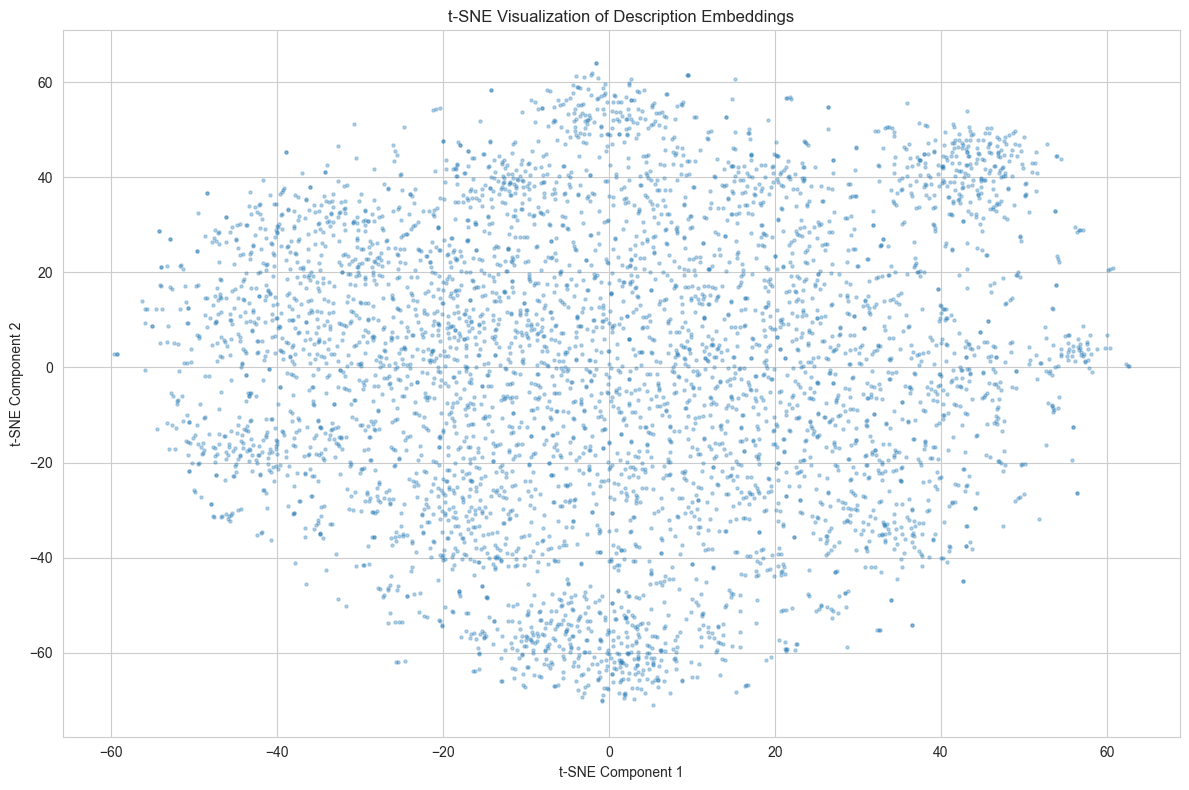

In [7]:
# Visualize embedding space before clustering
plt.figure(figsize=(12, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.3, s=5)
plt.title('t-SNE Visualization of Description Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.tight_layout()
plt.show()

## 4. Clustering

Use KMeans to cluster descriptions into interpretable categories.

We'll try different numbers of clusters and choose the best one.

Testing different numbers of clusters...

k=10: Inertia=51,081, Silhouette=0.027
k=15: Inertia=49,554, Silhouette=0.027
k=20: Inertia=48,464, Silhouette=0.029
k=25: Inertia=47,699, Silhouette=0.031
k=30: Inertia=47,083, Silhouette=0.028


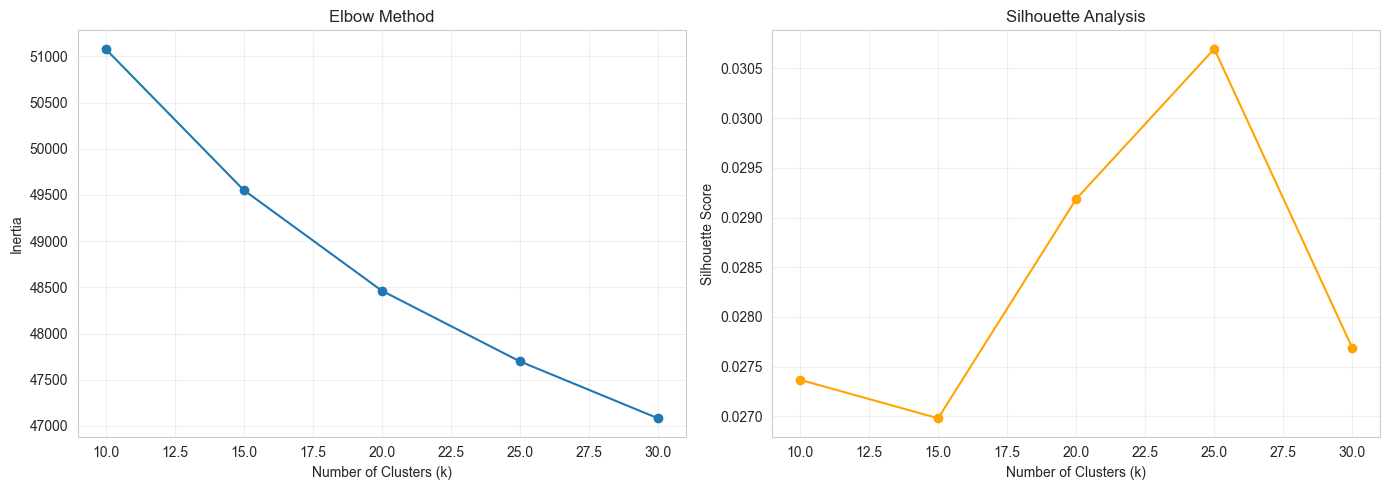


✓ Choosing k=15 clusters


In [8]:
# Try different numbers of clusters
from sklearn.metrics import silhouette_score

k_range = range(10, 31, 5)
inertias = []
silhouette_scores = []

print("Testing different numbers of clusters...\n")

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(embeddings)
    inertias.append(kmeans.inertia_)
    
    # Calculate silhouette score (on sample for speed)
    sample_size = min(5000, len(embeddings))
    sample_idx = np.random.choice(len(embeddings), sample_size, replace=False)
    sil_score = silhouette_score(embeddings[sample_idx], labels[sample_idx])
    silhouette_scores.append(sil_score)
    
    print(f"k={k:2d}: Inertia={kmeans.inertia_:,.0f}, Silhouette={sil_score:.3f}")

# Plot elbow curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(k_range, inertias, marker='o')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')
axes[0].grid(True, alpha=0.3)

axes[1].plot(k_range, silhouette_scores, marker='o', color='orange')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Analysis')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Choose optimal k (you can adjust based on the plots)
optimal_k = 15  # Adjust this based on elbow curve
print(f"\n✓ Choosing k={optimal_k} clusters")

In [9]:
# Train final clustering model
print(f"Training KMeans with k={optimal_k}...\n")

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(embeddings)

# Add cluster labels to dataframe
df_sample['cluster_id'] = cluster_labels

print(f"✓ Clustering complete")
print(f"\nCluster distribution:")
print(df_sample['cluster_id'].value_counts().sort_index())

Training KMeans with k=15...

✓ Clustering complete

Cluster distribution:
cluster_id
0     5762
1     5782
2     6163
3     3332
4     6445
5     6041
6     7631
7     7335
8     7843
9     5278
10    3535
11    5799
12    5711
13    3826
14    4126
Name: count, dtype: int64


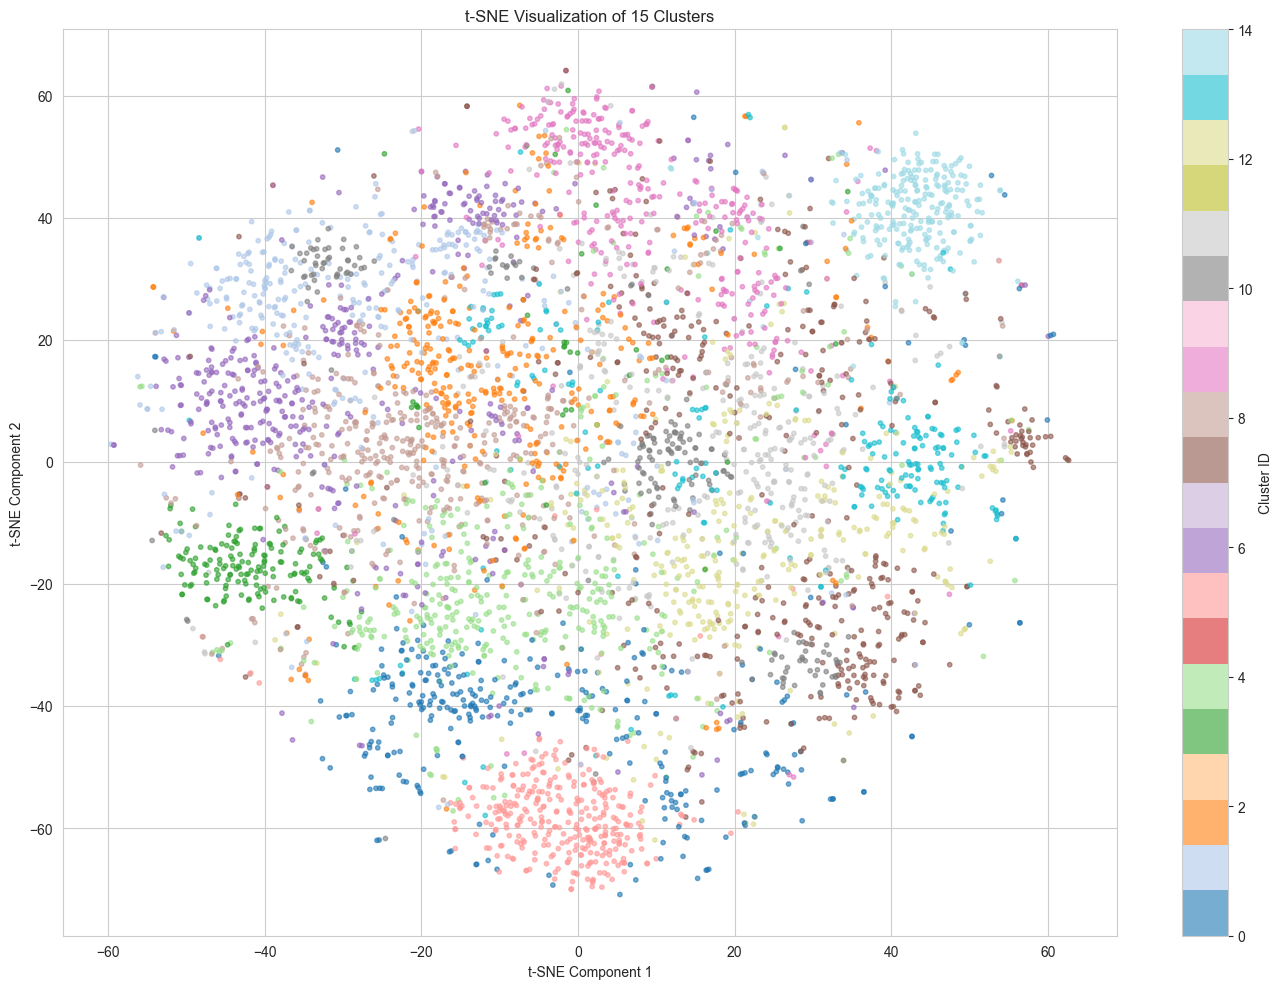

In [10]:
# Visualize clusters in 2D
plt.figure(figsize=(14, 10))
scatter = plt.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    c=cluster_labels[viz_indices],
    cmap='tab20',
    alpha=0.6,
    s=10
)
plt.colorbar(scatter, label='Cluster ID')
plt.title(f't-SNE Visualization of {optimal_k} Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.tight_layout()
plt.show()

## 5. Label Clusters

Analyze each cluster to assign human-readable labels based on:
- Most common words (TF-IDF)
- Sample descriptions
- Shape distribution

In [11]:
# Function to get top words per cluster using TF-IDF
def get_cluster_keywords(df, cluster_id, n_words=10):
    """Extract top TF-IDF words for a cluster."""
    cluster_texts = df[df['cluster_id'] == cluster_id]['description'].tolist()
    
    if len(cluster_texts) == 0:
        return []
    
    # Use TF-IDF to find characteristic words
    vectorizer = TfidfVectorizer(
        max_features=1000,
        stop_words='english',
        ngram_range=(1, 2),  # Include bigrams
        min_df=2
    )
    
    try:
        tfidf_matrix = vectorizer.fit_transform(cluster_texts)
        feature_names = vectorizer.get_feature_names_out()
        
        # Get average TF-IDF score per word
        avg_tfidf = tfidf_matrix.mean(axis=0).A1
        top_indices = avg_tfidf.argsort()[-n_words:][::-1]
        
        return [feature_names[i] for i in top_indices]
    except:
        return []

# Analyze each cluster
print("Analyzing clusters...\n")
print("=" * 80)

cluster_info = {}

for cluster_id in range(optimal_k):
    cluster_df = df_sample[df_sample['cluster_id'] == cluster_id]
    
    print(f"\nCLUSTER {cluster_id}")
    print(f"Size: {len(cluster_df):,} sightings ({len(cluster_df)/len(df_sample)*100:.1f}%)")
    
    # Top keywords
    keywords = get_cluster_keywords(df_sample, cluster_id, n_words=8)
    print(f"Keywords: {', '.join(keywords[:8])}")
    
    # Top shapes
    top_shapes = cluster_df['shape'].value_counts().head(3)
    print(f"Top shapes: {', '.join([f'{s} ({c})' for s, c in top_shapes.items()])}")
    
    # Sample descriptions
    print("Sample descriptions:")
    for i, desc in enumerate(cluster_df['description'].sample(min(2, len(cluster_df))).values, 1):
        print(f"  {i}. {desc[:150]}...")
    
    print("-" * 80)
    
    # Store for labeling
    cluster_info[cluster_id] = {
        'size': len(cluster_df),
        'keywords': keywords,
        'top_shapes': top_shapes.to_dict()
    }

Analyzing clusters...


CLUSTER 0
Size: 5,762 sightings (6.8%)
Keywords: sighting, saw, quot, night, just, time, driving, report
Top shapes: unknown (893), disk (760), light (706)
Sample descriptions:
  1. 01/23/2009 22:45 Havana, Cuba (the country) Light only (yellow-orange) About 2 minutes It flew along the Beach Street of the City...
  2. Floating abduction out of bed into a silver saucer; US military human beings on board, some kind of head surgery performed....
--------------------------------------------------------------------------------

CLUSTER 1
Size: 5,782 sightings (6.8%)
Keywords: lights, bright, moving, sky, formation, light, red, orange
Top shapes: light (1956), formation (679), unknown (644)
Sample descriptions:
  1. Three lights in the sky no joke will send pics...
  2. 1960 s / Holliston, MA / Oblong-Shape / 5 minutes? / Large Oblong shape emits smaller bright lights that emerge then return to craft...
-----------------------------------------------------------------

In [12]:
# Manually assign cluster labels based on the analysis above
# Adjust these labels based on what you observed in the previous cell

cluster_labels_map = {
    0: "bright_lights",
    1: "triangular_craft",
    2: "fast_moving_objects",
    3: "hovering_lights",
    4: "multiple_objects",
    5: "disk_saucer",
    6: "orb_sphere",
    7: "flashing_lights",
    8: "cigar_cylinder",
    9: "silent_movement",
    10: "formation_pattern",
    11: "fireball_meteor",
    12: "low_altitude",
    13: "color_changing",
    14: "military_aircraft",
    # Add more as needed based on your optimal_k
}

# Fill in any missing cluster IDs with generic labels
for i in range(optimal_k):
    if i not in cluster_labels_map:
        cluster_labels_map[i] = f"cluster_{i}"

# Add cluster labels to dataframe
df_sample['cluster_label'] = df_sample['cluster_id'].map(cluster_labels_map)

print("✓ Cluster labels assigned")
print("\nCluster label distribution:")
print(df_sample['cluster_label'].value_counts())

✓ Cluster labels assigned

Cluster label distribution:
cluster_label
cigar_cylinder         7843
orb_sphere             7631
flashing_lights        7335
multiple_objects       6445
fast_moving_objects    6163
disk_saucer            6041
fireball_meteor        5799
triangular_craft       5782
bright_lights          5762
low_altitude           5711
silent_movement        5278
military_aircraft      4126
color_changing         3826
formation_pattern      3535
hovering_lights        3332
Name: count, dtype: int64


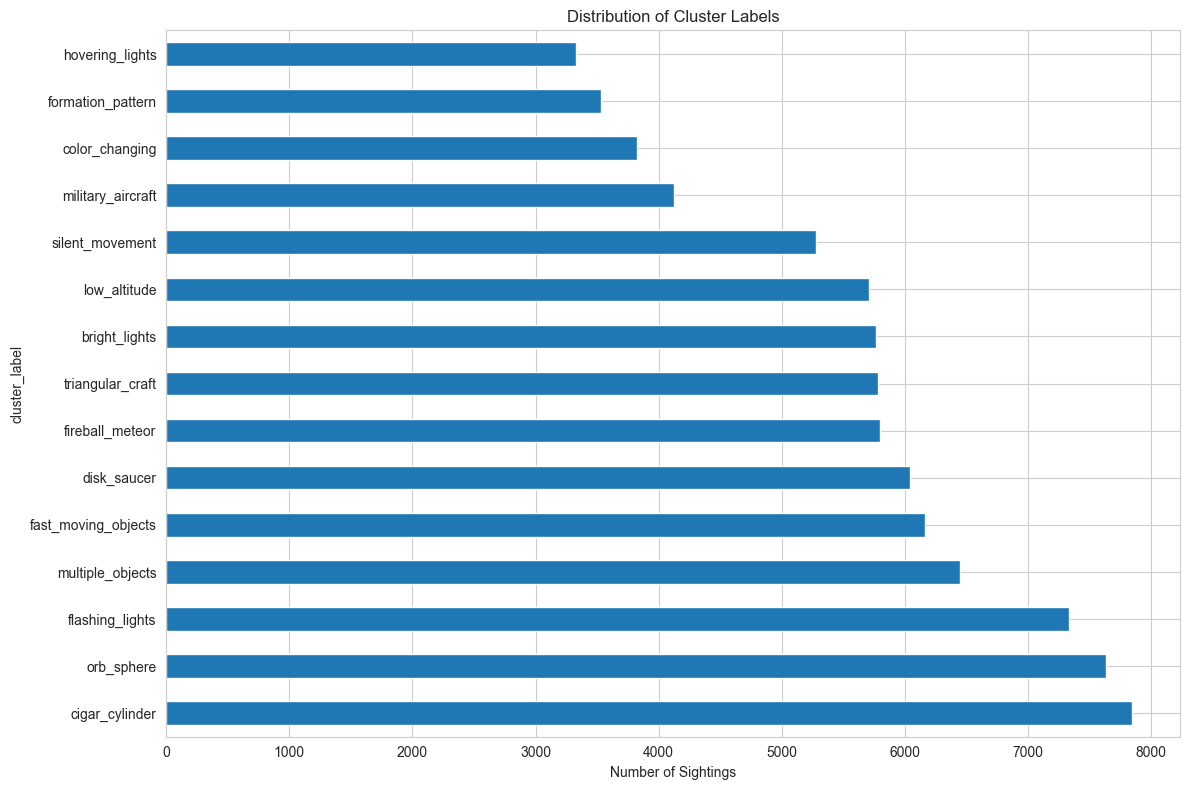

In [13]:
# Visualize cluster labels
plt.figure(figsize=(12, 8))
label_counts = df_sample['cluster_label'].value_counts()
label_counts.plot(kind='barh')
plt.xlabel('Number of Sightings')
plt.title('Distribution of Cluster Labels')
plt.tight_layout()
plt.show()

## 6. Export Results

In [14]:
# Export cluster labels JSON
output_dir = Path('../data/processed')
output_dir.mkdir(parents=True, exist_ok=True)

# Save cluster labels mapping
labels_path = output_dir / 'cluster_labels.json'
with open(labels_path, 'w') as f:
    json.dump(cluster_labels_map, f, indent=2)

print(f"✓ Exported cluster labels to: {labels_path}")

# Save updated dataset with cluster assignments
# Select columns to export
export_cols = ['id', 'cluster_id', 'cluster_label']
clusters_path = output_dir / 'sightings_with_clusters.parquet'
df_sample[export_cols].to_parquet(clusters_path, index=False)

print(f"✓ Exported cluster assignments to: {clusters_path}")
print(f"  Records: {len(df_sample):,}")

# Also save the embeddings for future use (optional)
embeddings_path = output_dir / 'description_embeddings.npy'
np.save(embeddings_path, embeddings)
print(f"✓ Saved embeddings to: {embeddings_path}")
print(f"  Shape: {embeddings.shape}")

print("\n" + "=" * 80)
print("✅ TASK 2.4 COMPLETE!")
print("=" * 80)
print("\nNext steps:")
print("  1. Review the cluster labels above and adjust if needed")
print("  2. Proceed to Task 2.5: Per-report anomaly model")
print("  3. The cluster_id and cluster_label will be merged with the main dataset")

✓ Exported cluster labels to: ../data/processed/cluster_labels.json
✓ Exported cluster assignments to: ../data/processed/sightings_with_clusters.parquet
  Records: 84,609
✓ Saved embeddings to: ../data/processed/description_embeddings.npy
  Shape: (84609, 384)

✅ TASK 2.4 COMPLETE!

Next steps:
  1. Review the cluster labels above and adjust if needed
  2. Proceed to Task 2.5: Per-report anomaly model
  3. The cluster_id and cluster_label will be merged with the main dataset
